In [1]:
from intelligent_placer_lib import intelligent_placer

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt

from imageio import imread
from skimage.color import rgb2gray
from skimage.filters import gaussian, try_all_threshold, threshold_otsu
from skimage.morphology import binary_opening, binary_closing
from skimage.measure import regionprops
from skimage import measure
from scipy import ndimage as ndi
import cv2

In [3]:
ITEMS_PATH = "./items"
DATASET_PATH = "./test_input/images"

# Обработка фотографий с отдельными предметами

background.jpg


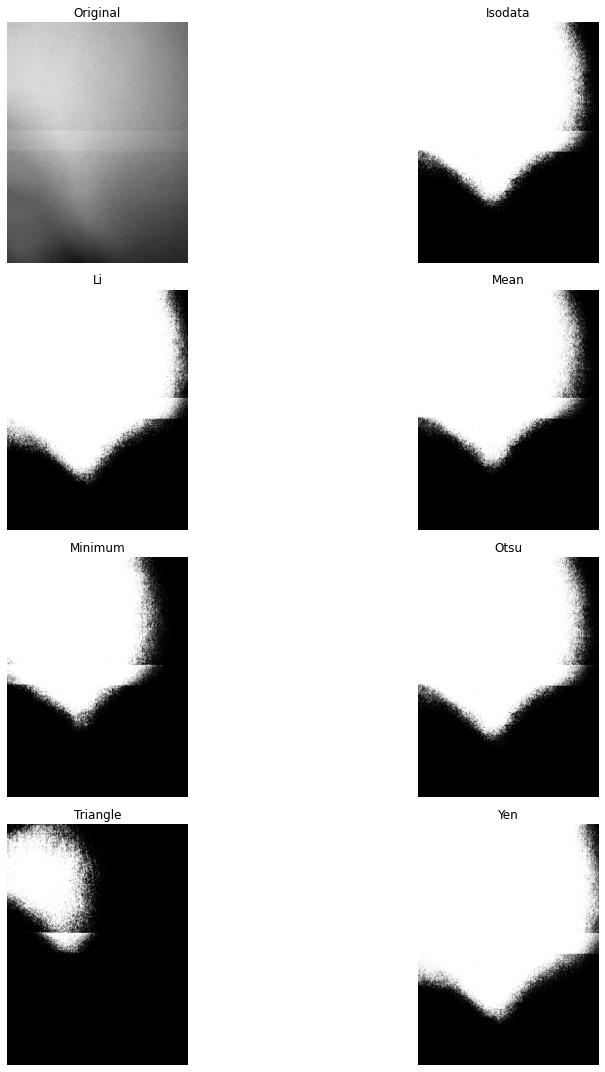

card.jpg


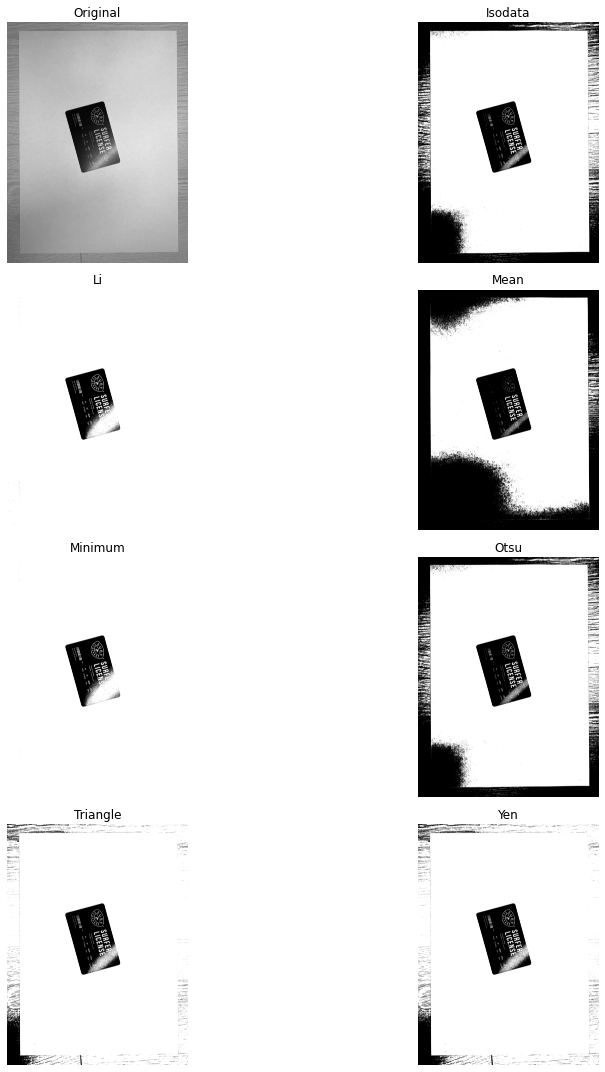

corrector.jpg


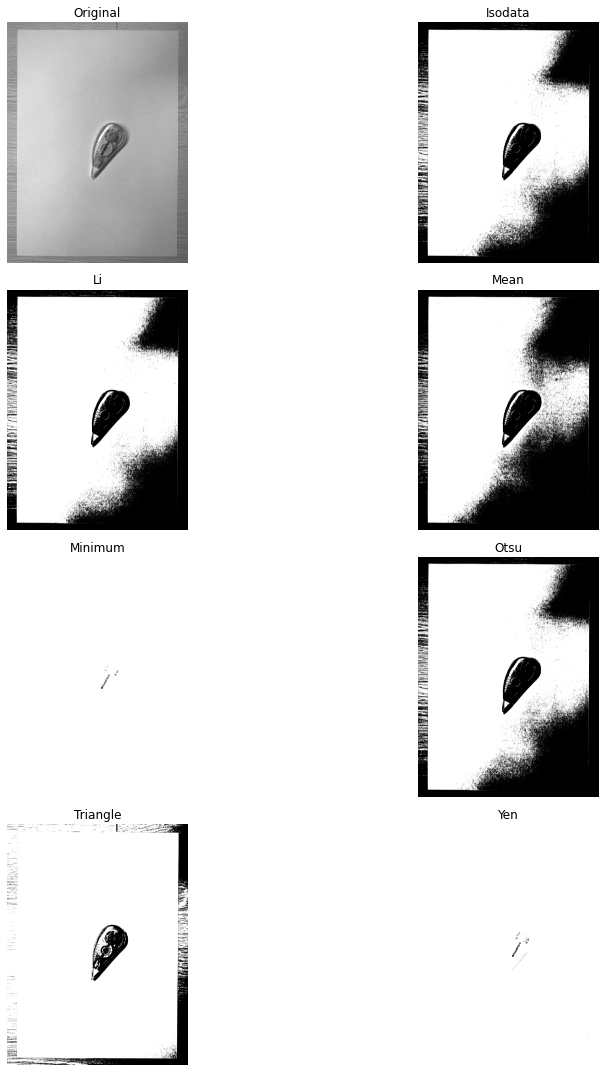

cream.jpg


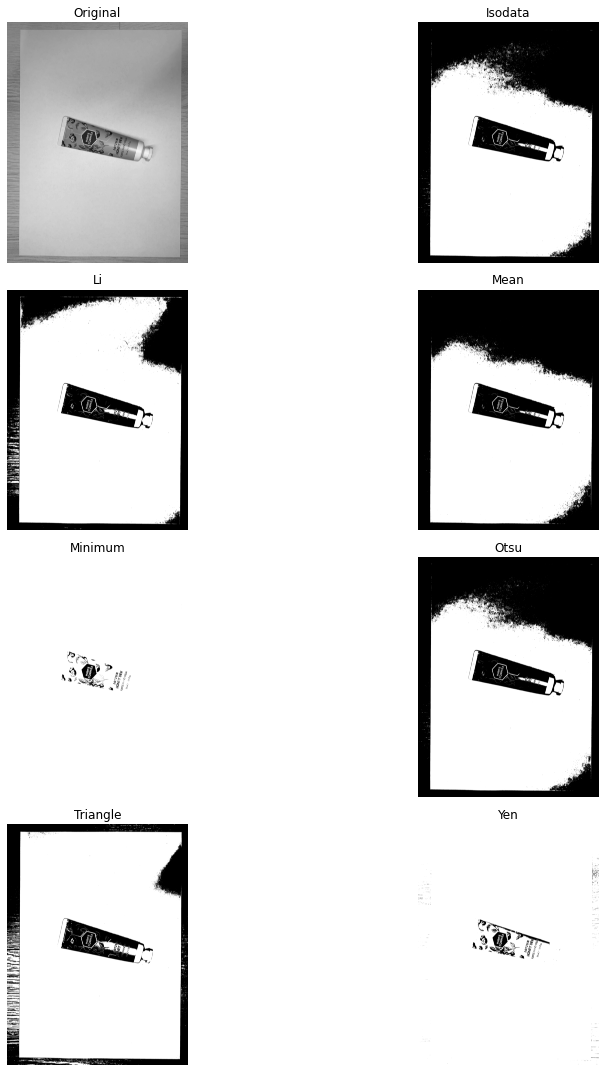

crystal.jpg


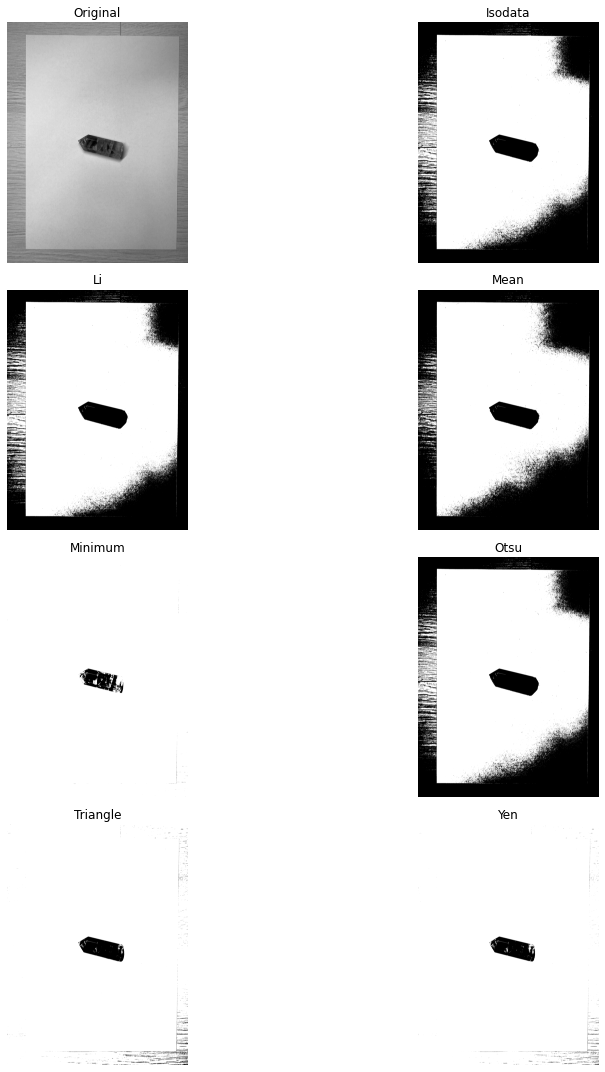

gum.jpg


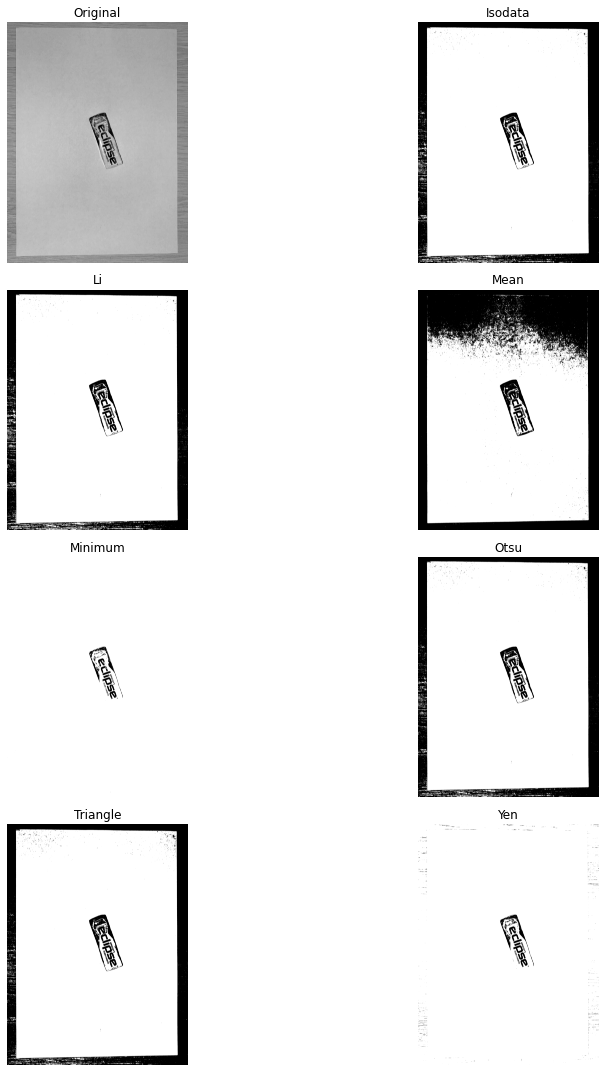

highlighter.jpg


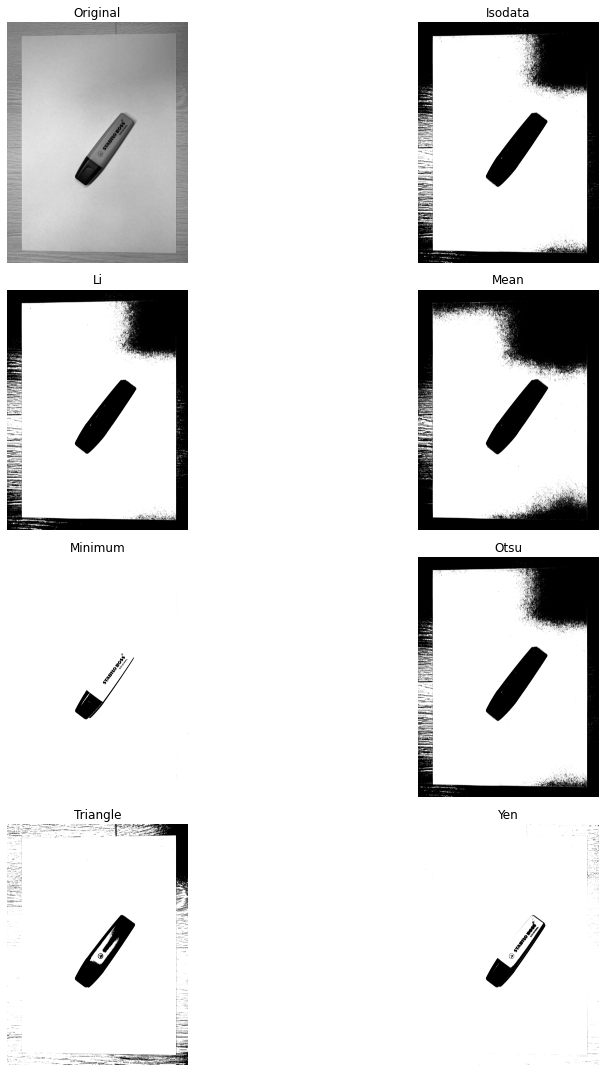

key.jpg


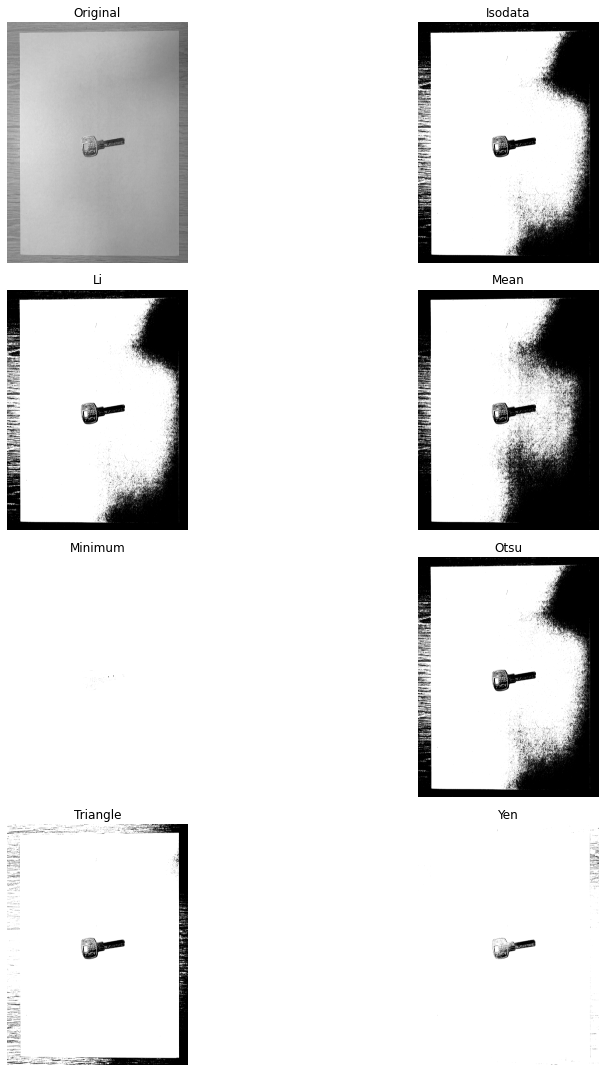

napkins.jpg


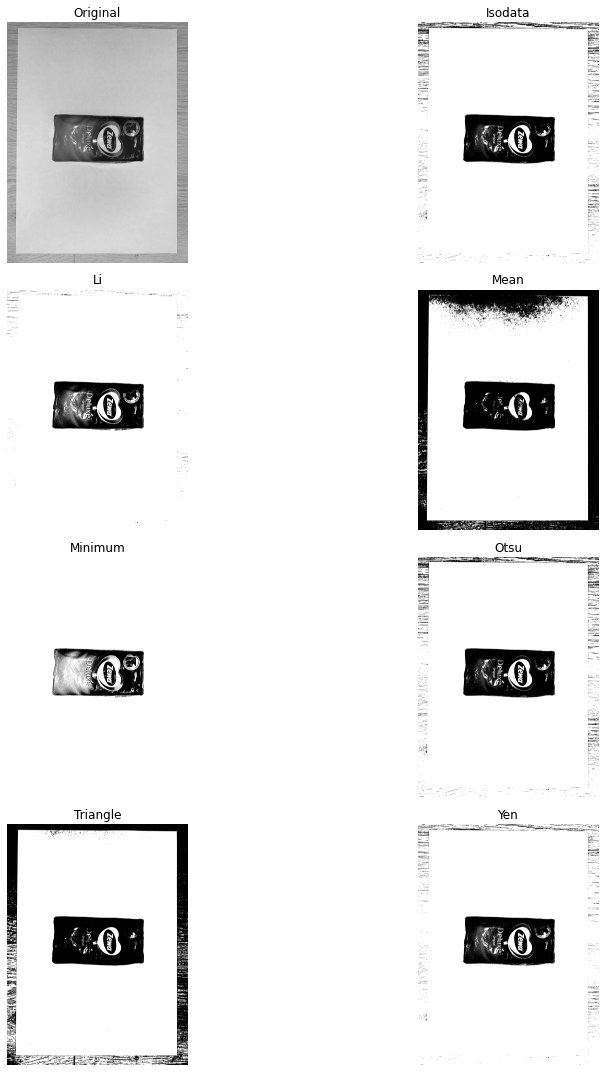

perfume.jpg


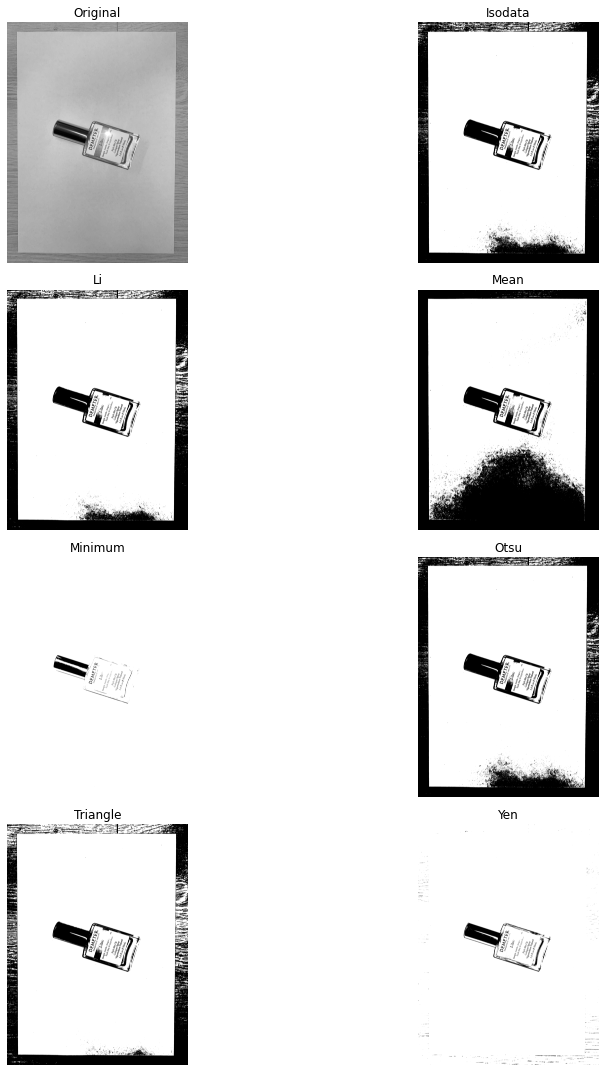

pick.jpg


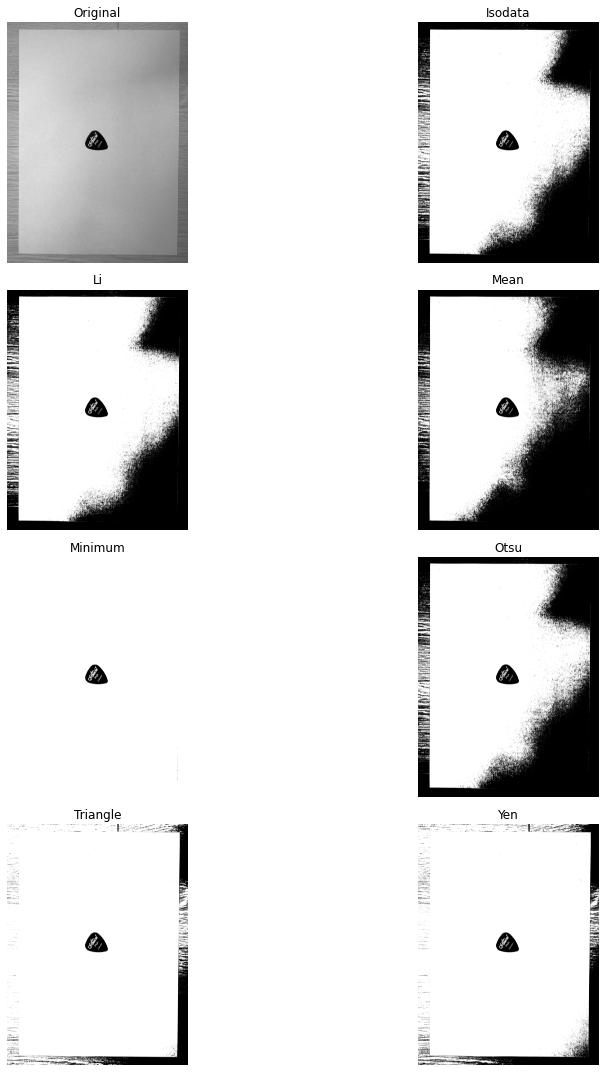

In [4]:
# посмотрим на разные методы бинаризации изображения
# как и ожидалось, бинаризация Оцу проявляет себя неплохо в сравнении с другими, попробуем поработать с ней
for img_path in os.listdir(ITEMS_PATH):
    img = imread(os.path.join(ITEMS_PATH, img_path))
    fig, ax = try_all_threshold(rgb2gray(img), figsize=(15, 15), verbose=False)
    print(img_path)
    plt.show()

## Обрезка изображения по листу

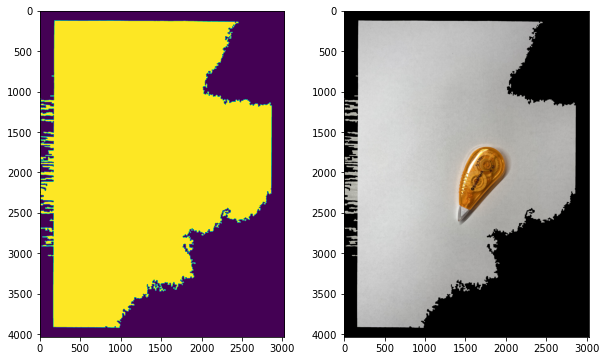

In [5]:
# попробуем вырезать все, что находится за пределами листа на изображении
img_path = os.path.join(ITEMS_PATH, "corrector.jpg")
img = imread(img_path)

img_blur_gray = rgb2gray(gaussian(img, sigma=1.5, channel_axis=True))
# бинаризация изображения
threshold_img = threshold_otsu(img_blur_gray)
result_image = img_blur_gray >= threshold_img
# морфологические операции
result_image = binary_opening(result_image, footprint=np.ones((10, 10)))
result_image = binary_closing(result_image, footprint=np.ones((10, 10)))

# выберем лист как наибольшую компоненту связности
labels = measure.label(result_image)
props = regionprops(labels)
mask_id = np.array([p.area for p in props]).argmax()
mask = (labels == (mask_id + 1))
# заполним дырки
mask = ndi.binary_fill_holes(mask)

# вырежем изображение по маске
visMask = (mask * 255).astype("uint8")
img = cv2.bitwise_and(img, img, mask=visMask)

ig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(mask)
ax[1].imshow(img)

# как видно из получившегося изображения, несмотря на достаточно равномерное освещение в кадре, не получается обрезать лист достаточно хорошо, поэтому пока отложим эту идею

## Выбор компоненты, соответствующей объекту

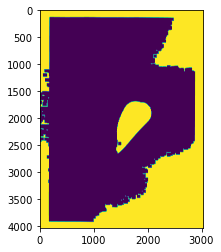

In [6]:
img_path = os.path.join(ITEMS_PATH, "corrector.jpg")
img = imread(img_path)

# не будем сжимать изображение, так как это ухудшает качество распознавания, а здесь мы хотим получить наиболее точные маски предметов
# img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)))

img_blur_gray = rgb2gray(gaussian(img, sigma=1.5, channel_axis=True))
# бинаризация изображения
threshold_img = threshold_otsu(img_blur_gray)
result_image = img_blur_gray <= threshold_img
# морфологические операции для улучшения полученной маски
result_image = binary_opening(result_image, footprint=np.ones((10, 10)))
result_image = binary_closing(result_image, footprint=np.ones((50, 50)))
plt.imshow(result_image)

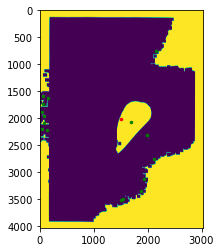

In [7]:
# на маске присутсвует много лишних компонент связности, попробуем отобрать нужную нам, используя то, что объект расположен в центре изображения
labels = measure.label(result_image)
props = regionprops(labels)
# посмотрим на центроиды всех компонент связности
plt.imshow(result_image)
center = (img.shape[0] / 2, img.shape[1] / 2)
plt.plot(center[1], center[0], '.r', markersize=5)
for prop in props:
    plt.plot(prop.centroid[1], prop.centroid[0], '.g', markersize=5)

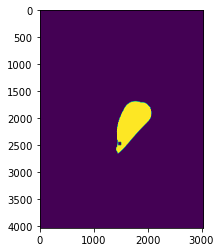

In [8]:
# выбираем компоненту, центроид которой расположен наиболее близко к центру
dist = np.array([pow(center[0] - p.centroid[0], 2) + pow(center[1] - p.centroid[1], 2) for p in props ])
mask_id = dist.argmin()
mask = (labels == (mask_id + 1))
plt.imshow(mask)

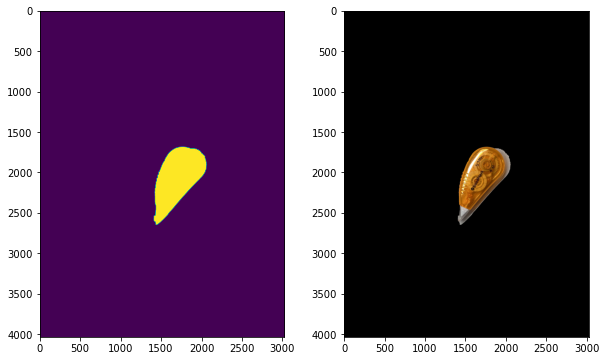

In [9]:
# еще раз закроем дыры в маске
mask = ndi.binary_fill_holes(mask)

# посмотрим, насколько хорошо с помощью полученной маски вырезается объект
visMask = (mask * 255).astype("uint8")
result_image = cv2.bitwise_and(img, img, mask=visMask)

ig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(mask)
ax[1].imshow(result_image)

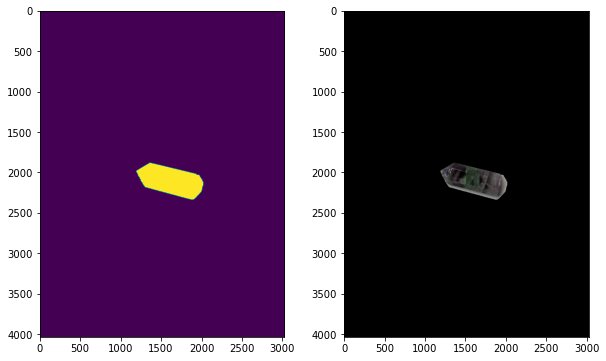

In [14]:
# вынесем полученную последовательность действий в отдельную функцию и посмотрим результат ее работы на других объектах
from intelligent_placer_lib.modules import object_data_preprocessing

img_path = os.path.join(ITEMS_PATH, "crystal.jpg")
mask_crystal = object_data_preprocessing.get_mask_from_object_img(img_path)

img = imread(img_path)
visMask = (mask_crystal * 255).astype("uint8")
result_image = cv2.bitwise_and(img, img, mask=visMask)

ig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(mask_crystal)
ax[1].imshow(result_image)

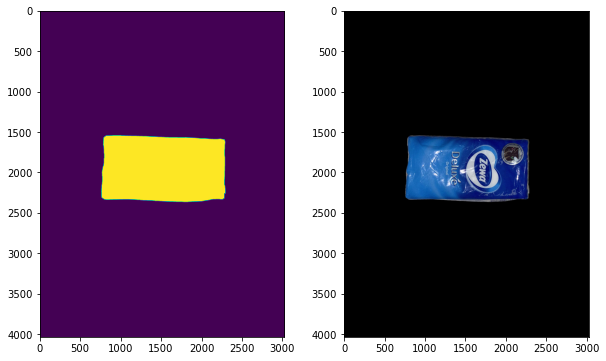

In [15]:
img_path = os.path.join(ITEMS_PATH, "napkins.jpg")
mask_napkins = object_data_preprocessing.get_mask_from_object_img(img_path)

img = imread(img_path)
visMask = (mask_napkins * 255).astype("uint8")
result_image = cv2.bitwise_and(img, img, mask=visMask)

ig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(mask_napkins)
ax[1].imshow(result_image)